**Automated Pricing Tool For Second Hand Car Shops Clients**


As explained in the presentation provided to the project, this tool aims to bring tools of the 21st century to a business that yet has not seen disruption by the big data tools 

Second Hand Car Shops are disinsentivising their clients wanting to sell their car by very opaque processes of the car pricing 

Therefore, a mechanism used for lead generation of the potential suppliers of the used cars needs improving

That is why in this notebook, a tool for automated pricing of cars in presented. Such a tool could be simply used by car owners willing to sell their car. Whereas competitors would require the seller to fill in long and boring forms, the developed tool would show a direct price estimation after taking one picture of the car. Such a shortening of the customer journey would insentivise sellers to list on the company's platform and prioritize the company over competition

In [3]:
#Importing modules needed for the data scrapping and collection
import pandas as pd

from bs4 import BeautifulSoup
import urllib.request

import time 

from random import randint
import re

import matplotlib.pyplot as plt

from selenium import webdriver
import os

Combination of Selenium and BeautifulSoup used to scrape different websites in order to get the dataset which will be used for the analysis. The script is collecting pictures of individual cars as well as the price for which the car is sold on the website. The price will be used as the main variable in the image recognition system


In [ ]:
# Path used to initiate Selenium
PATH = r"C:\Users\Michal\Desktop\School\Bocconi\Courses\Business Analytics\chromedriver.exe"

driver = webdriver.Chrome(PATH)

The AAAAuto Czech company is used as the most reliable source of second hand cars in Czech Republic for the scraping, the address points to first page of "Used Cars" category

In [ ]:
# Website used for the scraping
driver.get("https://www.aaaauto.cz/ojete-vozy/#!&page=1")

Prices of each vehicle are collected separately from the pictures and then both are merged together

In [ ]:
#List where prices of individual cars will be stored is initiated for 400 pages of the website
car_prices = [[] for _ in range(400)]
counter = 1

Further, first the crawler through the site is set up using Selenium in the first lines of the loop (looping through the available pages)

After, BeautifulSoup parses the website and looks for price and stores all found. Lastly, same is repeated with all the pictures within the one page

In [ ]:
# Looping through pages of the website as the system blocks any other attempts to iterate over pages (direct access through URL changes is blocked)
for number in range(1,400):
    
    prices_holder = []
    
    # Selenium scrolling to the right part of the webpage where the button for next pahe is located
    driver.execute_script("window.scrollTo(0, 2800);") 

    # Selenium searching for the button with the number of the next page and clicking the found button
    link = driver.find_element_by_link_text(str(number+1))
    link.click()

    # Wait time to ensure proper load of the page before the usage of BeautifulSoup as well as to prevent being blocked by the website
    time.sleep(randint(9, 10))

    webpage = driver.page_source
    
    #Part of script where the scraper begins
    soup = BeautifulSoup(webpage, 'html.parser')

    html = soup.prettify('utf-8')
    
    # Scraping all the needed prices
    for h3 in soup.findAll('h3', attrs={'class':''}):
        prices_holder.append(h3.text.strip())
        
    car_prices[number].append(prices_holder)
    print("prices added")

    # Scraping for the car images 
    for image in soup.findAll('img', attrs={"itemprop":"thumbnail"}):
        image_src = image["src"]
        print(image_src)
        urllib.request.urlretrieve(image_src, str(counter))
        counter += 1 

In [ ]:
#Car prices list needs to be adjusted from list of lists to a single list
cptry2 = []
        
for k in car_prices:
    for l in k:
        for z in l:
            cptry2.append(z)

The prices are ready to be adjusted, first, prices the to be adjusted from Czech Crowns to Euroes and the "Kč" sign has to be removed

In [ ]:
# adjusting the proper price categories for the various classes we will later use as output of the model
car_prices_right = []


# first, proper format is obtained by RegEx (the division by 25 is adjustment from czech crowns to euroes)
for price in cptry2:
    x = re.findall('([^Kč]+)', price)[0]
    x = x.replace(" ","")
    car_prices_right.append(int(int(x)/25))

To understand how the prices are distributed (needed for creation of categories later used for the Neural Network), histogram is plotted

In [ ]:
# dataframe created to visualize and understand the categories
pd1 = pd.DataFrame(car_prices_right)

In [ ]:
# Decision to take 7 caterogies made from the histogram
plt.hist(pd1[0], color = 'blue', edgecolor = 'black', bins = int(2e6/60000)) 

Next, the prices need to be adjusted from the actual values to one of the categories listed in the for loop below (categories from €1,000 to €25,000)

In [ ]:
# need to bin all the values correctly (we take mean for every category)
for l in range(len(car_prices_right)):
        if (car_prices_right[l] >= 0) & (car_prices_right[l] < 2000):
            car_prices_right[l] = 1000
        elif (car_prices_right[l] >= 2000) & (car_prices_right[l] < 4500):
            car_prices_right[l]= 3000
        elif (car_prices_right[l] >= 4500) & (car_prices_right[l] < 7500):
            car_prices_right[l] = 6000
        elif (car_prices_right[l] >= 7500) & (car_prices_right[l] < 10500):
            car_prices_right[l]= 9000
        elif (car_prices_right[l] >= 10500) & (car_prices_right[l] < 15000):
            car_prices_right[l]= 12000
        elif (car_prices_right[l] >= 1500) & (car_prices_right[l] < 20000):
            car_prices_right[l]= 18000
        else:
            car_prices_right[l]= 25000

For the purpose of the later used Neural Network classification, the pictures need to be renamed accordingly to the price with the following code seen below 

In [ ]:
# Now, the files need to be named correctly to be used in the model later
def naming(car_prices_right, picture_pointer, i):
    while os.path.isfile(r'C:\Users\Michal\HOPEFULLY LAST CARS\converted2\\' + str(car_prices_right[picture_pointer]) + "_" + str(i) + ".jpg") :
        i += 1
    os.rename(r'C:\Users\Michal\HOPEFULLY LAST CARS\converted2\\' + str(picture_pointer) + ".jpg", r'C:\Users\Michal\HOPEFULLY LAST CARS\converted2\\' + str(car_prices_right[picture_pointer]) + "_" + str(i) + ".jpg")

for picture_pointer in range(0,4000):
    i = 0
    naming(car_prices_right, picture_pointer, i)

Now, the data is renamed and the last step of reorganization and uploading on the Google Drive is done by hand. Two different structures are used for the two different frameworks applied for the image classification task.

The following steps are taken for the structure used for Fastai package:

1. The data is uploaded to Google Drive
2. Train folder is created
3. Within the Train folder, subfolders called €1,000 , €2,000... are created
4. The pictures are distributed into the subfolders

The following steps are taken for the structure used for Keras:

1. The data is uploaded to Google Drive
2. Train, Valid and Test folders is created
3. Within the each folder, subfolders called €1,000 , €2,000... are created
4. The pictures are distributed into the subfolders


**The Image Classification**

Once the data is finally ready, classification is performed first using Fastai and then Keras

In [5]:
#Google Colab always removed the installation of the two following packages, therefore the installation command is added 
!pip install GPUtil
!pip install cache_magic

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a0a34db4f85c2a44525bfa13048d7cbe1a77a9e0eb1a7290c695d3c9c5d8c4c9
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
  Created wheel for cache-magic: filename=cache_magic-1.0.4-cp36-none-any.whl size=6698 sha256=fe083ceb735b5ea65409428a1c24ca1410d37b6e2b806dca3a71949488753bdd
  Stored in directory: /root/.cache/pip/wheels/84/3a/44/00b6aea43fe9fcd0c86bbcf33b7e45d167a6b6a1803983325e
Successfully built cache-magic


In [6]:
#First Module (Fast.ai) to be used for a fast setup of the vision learning system
from fastai.vision import *
import cache_magic
import psutil
import humanize
import os
import GPUtil as GPU

In [7]:
#All the data used for training will be cached as communication between Google Drive and Google Colab slows down the training of the model extensively
#Therefore, first the cache is cleaned 
%cache -r
!rmdir .cache/

Resetting entire cache


In [7]:
#Data loaded from a Google Drive file and cached in the previously cleaned space in order to eliminate the data transfer during the traning 
path = Path(r"/content/drive/My Drive/converted2")
!mkdir .cache
!ln -s '/content/drive/My Drive/converted2.cache' /content/.cache

In [15]:
#Dataset raises a lot of warnings when the right version of torch is not installed 
#Therefore the next lines help to setup the environment capable of training of the data
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 54.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


Data is loaded into DataBunch object and divided into training and validation set. Transformation and normalization is performed as the model performs poorly without said steps

In [8]:


#In order to speed up the data loading into the model (without it the system took an hour / epoch), data is cached into RAM
%cache data = ImageDataBunch.from_folder(path, valid_pct = 0.2, ds_tfms=get_transforms(), size=224, bs = 16).normalize(imagenet_stats)


Creating new value for variable 'data'


As the model would be untrainable on CPU, GPU of the Google Colab is utilized. Therefore, before the beginning of the training, GPU is set up 

In [ ]:
#Because of the slow data input into the model, GPU availability is checked every time
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Code used to check the utilization of the GPU, if any of the previous tasks are still running GPU RAM can be cleaned before the training
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 9.9 GB  | Proc size: 4.4 GB
GPU RAM Free: 14068MB | Used: 1011MB | Util   7% | Total 15079MB


With the data loaded into the cache, system is ready for learning. Pretrained ResNet152 on ImageNet data is use for the task after using the more shallow architectures that performed poorly

In [9]:

#13 epochs are set in order to stop the training before overfitting as from the following epochs onwards, validation loss stagnates or increases
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.fit_one_cycle(13)

epoch,train_loss,valid_loss,accuracy,time
0,2.649115,1.862073,0.356968,01:54
1,2.331465,1.712179,0.400978,01:52
2,1.868400,1.459782,0.427873,01:53
3,1.567431,1.375741,0.425428,01:53
4,1.456204,1.399090,0.441320,01:55
5,1.332332,1.223642,0.492665,01:55
6,1.320005,1.179118,0.508557,01:54
7,1.256435,1.140305,0.518337,01:53
8,1.188801,1.064296,0.548900,01:51
9,1.079825,1.085304,0.544010,01:51


Let's now inspect the results on the model in the code below

In [10]:
#Setting up the model's results to explore where is the problem with the learning accuracy
interp = ClassificationInterpretation.from_learner(learn)

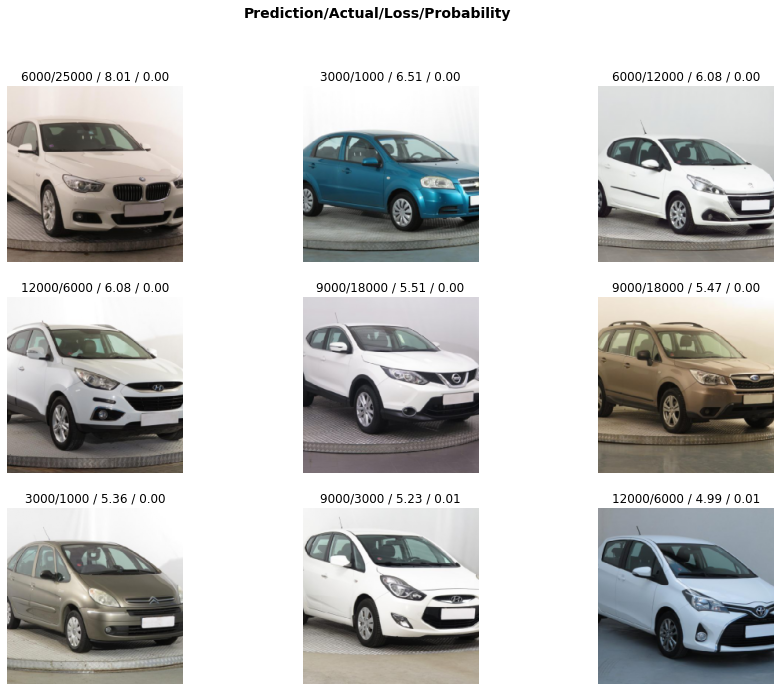

In [11]:
#Let's see where are the biggest errors in predictions
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

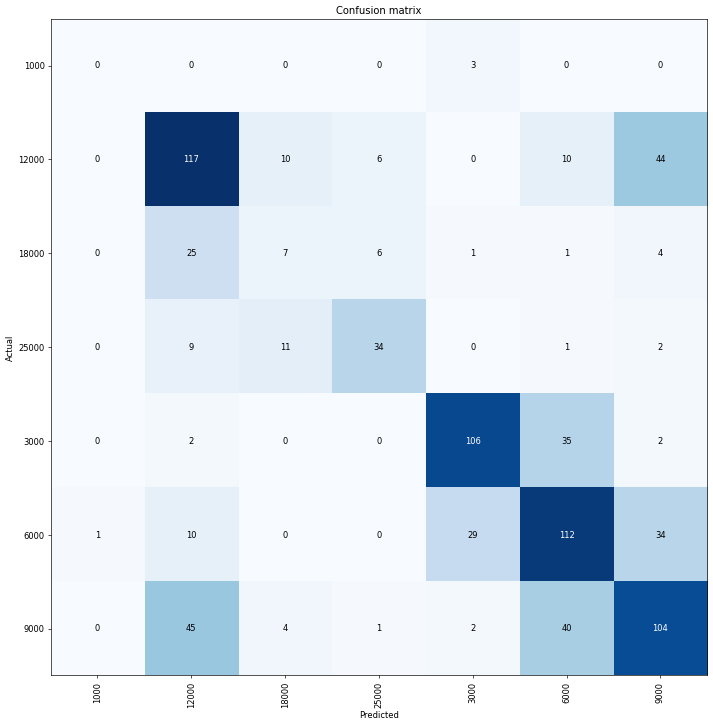

In [12]:
#To see better the reason the outcome of a low accuracy, let's look at which classes get misinterpretted the most
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can see that the higher rate of errors (misclassifications) is between adjacent price classes (€9k or €12k etc.)


In [13]:
interp.most_confused(min_val=2)

[('9000', '12000', 45),
 ('12000', '9000', 44),
 ('9000', '6000', 40),
 ('3000', '6000', 35),
 ('6000', '9000', 34),
 ('6000', '3000', 29),
 ('18000', '12000', 25),
 ('25000', '18000', 11),
 ('12000', '18000', 10),
 ('12000', '6000', 10),
 ('6000', '12000', 10),
 ('25000', '12000', 9),
 ('12000', '25000', 6),
 ('18000', '25000', 6),
 ('18000', '9000', 4),
 ('9000', '18000', 4),
 ('1000', '3000', 3),
 ('25000', '9000', 2),
 ('3000', '12000', 2),
 ('3000', '9000', 2),
 ('9000', '3000', 2)]

Last step we can take is to look for right hyper-parameter and unfreeze the model's convolutional base

In [14]:
#After analyzing the performance, the model will be fine-tuned and the right learning rate will be found
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


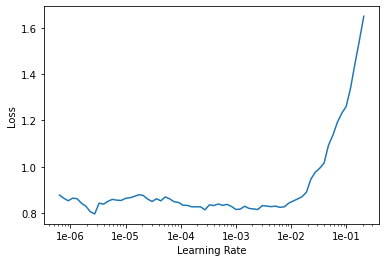

In [15]:
#Visualisation of the learning rate for more clarity
learn.recorder.plot()

We can clearly see the best learning rate being between 1e-06 and 1e-05 and therefore this interval will be used 

In [16]:
#Fine-tuning is attempted with the previously found best learning rate
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.758390,1.004593,0.575795,02:02
1,0.754611,1.009688,0.580685,02:02
2,0.742747,0.997012,0.588020,02:00
3,0.708516,1.012809,0.579462,01:59


After the fine-tuning of the Fastai, the attention is turned to Keras to see if the performance can be improved with the higher varibility of components offered by Keras

In [7]:
# As the fast.ai results were lower than expected, Keras version will be implemented 
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

Next we get rid of the cached files so we could work with the new directory we need (different structure needed for Keras)


In [8]:
#Data are separated into Train, Valid (same as for Fast.ai) but also Test set, which is not used in the Fast.ai framework 
%cache -r
!rmdir .cache/

Resetting entire cache


Same code as before is used to cache the data

In [8]:
#Data loaded from a Google Drive file with the correct data structure for Keras
!mkdir .cache
!ln -s '/content/drive/My Drive/convertedKERAS.cache' /content/.cache

As the data from another source than the library itself is used, the data pipeline has to be set up first before any training can be performed

In [9]:
#ImageDataGenerator class used for the data pipeline setup from the Google Drive
from keras.preprocessing.image import ImageDataGenerator

#Data are rescaled and transformed to enlarge the variation space of the data seen by the system in training 
train_datagen = ImageDataGenerator(rescale=1./255, 
            samplewise_center=True,
            samplewise_std_normalization=True,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,)

#For the test set, data are only rescaled but not transformed 
test_datagen = ImageDataGenerator(rescale=1./255)

#Paths to all the three needed directories are set up
train_dir = '/content/drive/My Drive/convertedKERAS/Train'
validation_dir = '/content/drive/My Drive/convertedKERAS/Valid'
test_dir = '/content/drive/My Drive/convertedKERAS/test'

#Whole pipeline is put together
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20)
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20)

Found 3073 images belonging to 7 classes.
Found 511 images belonging to 7 classes.
Found 509 images belonging to 7 classes.


After setting up the pipeline, pretrained ResNet152 is used to be fitted on the dataset as in the Fastai case

In [10]:
#Using the ResNet152V2 pretrained on the imagenet without the top layer to perform feature selection
from keras.applications import ResNet152V2

conv_base = ResNet152V2(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

234553344/234545216 [==============================] - 2s 0us/step


On top of the trained convolutional base, the head layers are added 

In [11]:
#Using the pretrained ResNetV2 model with a new clasifier on top for the task
from keras import models
from keras import layers
from keras import optimizers

#The convolution base weights are frozen to prevent training of the pretrained network
conv_base.trainable = False 

#No dropout layer is used in the head as the training does not show signs of overfitting
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

#Softmax used because of the number of classes and the nature of the task (classification)
model.add(layers.Dense(7, activation='softmax'))

In [13]:
#compiling the model, categorical crossentropy is used as loss because of the higher number of classes
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc'])

#Fitting the model, larger number of epochs is chosen because of the low amount of data
history = model.fit_generator(train_generator, steps_per_epoch=150, epochs=30, validation_data=validation_generator, validation_steps=20)

Epoch 1/30
150/150 [==============================] - 54s 361ms/step - loss: 1.6167 - acc: 0.2977 - val_loss: 1.6689 - val_acc: 0.2975
Epoch 2/30
150/150 [==============================] - 51s 340ms/step - loss: 1.6107 - acc: 0.2813 - val_loss: 1.6666 - val_acc: 0.2900
Epoch 3/30
150/150 [==============================] - 51s 340ms/step - loss: 1.6099 - acc: 0.2870 - val_loss: 1.6807 - val_acc: 0.2925
Epoch 4/30
150/150 [==============================] - 51s 343ms/step - loss: 1.6133 - acc: 0.3024 - val_loss: 1.6701 - val_acc: 0.2725
Epoch 5/30
150/150 [==============================] - 51s 338ms/step - loss: 1.6020 - acc: 0.3147 - val_loss: 1.7351 - val_acc: 0.2575
Epoch 6/30
150/150 [==============================] - 51s 337ms/step - loss: 1.5984 - acc: 0.3114 - val_loss: 1.7256 - val_acc: 0.2625
Epoch 7/30
150/150 [==============================] - 51s 339ms/step - loss: 1.5953 - acc: 0.3017 - val_loss: 1.6214 - val_acc: 0.2950
Epoch 8/30
150/150 [==============================] - 5

As the next step, the number of epochs and parameters has to be studied to understand whether the model is under or overfitting

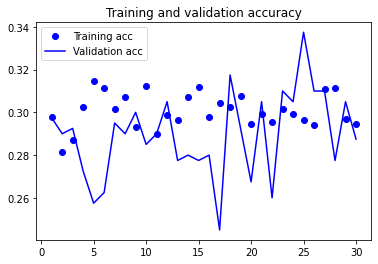

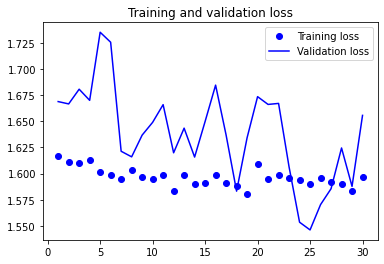

In [14]:
#Plotting the accuracies and losses from the saved history fitted model to check for training performance and overfitting
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As the validation and training loss seem to be on a very similar trendline, there is no evidence of overfitting of the model 

In [15]:
model.evaluate(test_generator)

26/26 [==============================] - 190s 7s/step - loss: 1.6432 - acc: 0.2672


[1.6431597471237183, 0.2671905755996704]

In the end, Fastai is performing much better on the task, even after manual hyper-parameters optimization, most probably thanks to a) slightly larger amount of data used in training b) better hyper-parameters optimization. 

**Extra: Image generation through WGAN**

On top of the previous tasks, very interesting feature that could entertain the customers using the tool would be generation of various other cars fitting into the same price category. Therefore an attempt for a WGAN generator is performed in the following code

In [ ]:
#Fast.ai trial for GAN implementation to create new examples from the different car price categories 
from fastai.vision import *
from fastai.vision.gan import *

In [ ]:
#The data pipeline for the GAN model that will be implemented is set up, data are normalized and transformed
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

After defining the function used for data ingestion, the same folder structure as the one used in the case of Fastai implementation is used

In [ ]:
#As for the GAN setup, as much data as possible is neeeded, the larger dataset with all the pictures is used for the training
path = Path(r"/content/drive/My Drive/converted2")

In [ ]:
#The previously set up data pipeline is used
data = get_data(128, 64)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 3931,2615
  warn(warn_msg)


After the pipeline is set up, following is the code for generation of the new images

In [ ]:
#The two parts of the GAN network which will be trained are initiated
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [ ]:
#Learning of the GAN is set up and initiated
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

Next, the training of the WGAN is initiated

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.490427,#na#,0.354710,-0.656175,17:31
1,-0.749504,#na#,0.489488,-0.985877,01:38
2,-0.922388,#na#,0.568801,-1.200812,00:40
3,-1.033079,#na#,0.621231,-1.337756,00:40
4,-1.099626,#na#,0.655791,-1.419507,00:39
5,-1.095264,#na#,0.684332,-1.469602,00:39
6,-1.126930,#na#,0.702111,-1.504862,00:38
7,-1.147064,#na#,0.715324,-1.524936,00:38
8,-1.167748,#na#,0.726808,-1.543976,00:38
9,-1.172015,#na#,0.735079,-1.544194,00:37


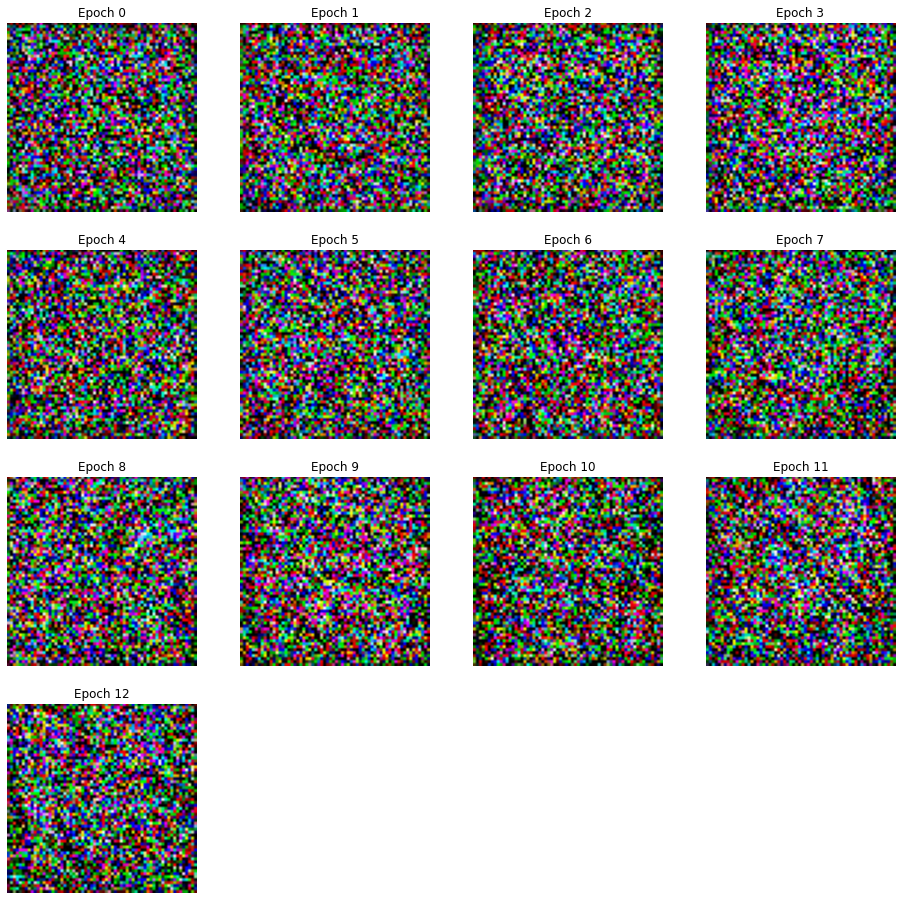

In [ ]:
#As GAN are typically known for the long training times, 300 epochs are used for training
learn.fit(300,2e-4)

The most challenging part of the training was the instability of the Google Colabs environment which is not very well suited for long training periods. The longest period without interuption achieved was around 6-7 hours and the results are shown below. Sadly, as can be seen from the previous pictures, the evolution of the training process has not been recorded properly and we can only see the last few generated images below

In [ ]:
#The outcome of the 300 epochs is saved for further usage to make sure the time demanding training is not lost
learn.save("trained_model")

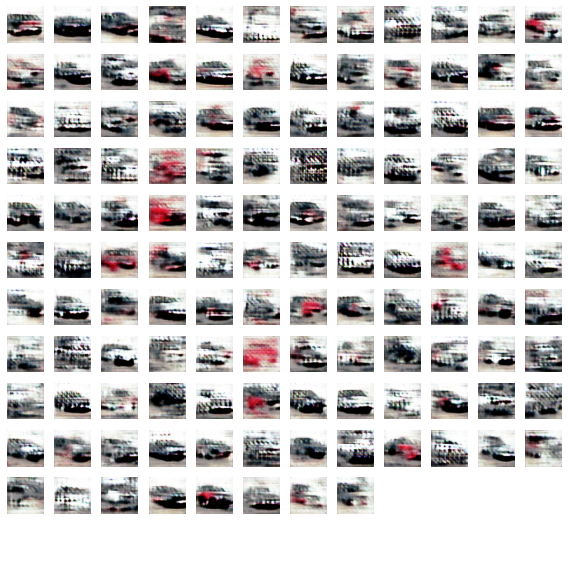

In [ ]:
#The examples of the new cars are presented, nevertheless the Colab environment was extremely unstable during the training of the GAN and failed multiple times
#Therefore, this is outcome of approximately 6-7hrs of continuous training which was the longest continuous training the envirnment was able to perform
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))

As can be seen the time was sadly not sufficiend for full training of the WGAN model. Nevertheless, from the pictures acquired it is noticable that the system was converging to actual vehicle images and therefore iterated in the right direction

**CONCLUSIONS**

In order to get a more precise model and the fully functional tool with accuracy over 90%, furher improvements would be needed. 

The proposed improvements would be the following:

1. More data collected
2. Scrape other categorical data available on the website except price
3. Build a mixed input model combining the output of the computer vision model with a prediction from the other categorical and numerical data scrapped (especially the amount of kilometers driven would be very useful)

In [ ]:
(link to the original Google Colab enviroment is added here:https://colab.research.google.com/drive/1PNE_7WbRykKscsW1OBId3xQR5T6F661i?usp=sharing)